# Stage 6 AI training: Data augmentation and training dataset size

This stage focuses on **data augmentation and the size of the training dataset**. Different rotational frames will be used for every fine data augmentation and size options.

In [2]:
# Import packages:
import MLQDM.MLmodel as ML_MLmodel
import MLQDM.timewindows as ML_twdw
import tensorflow as tf

# Check available GPU:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load original data and general parameters
Load data from files (many segments) and store information in dataframes, one for each segment. The original data is in the **Laboratory rotational frame (RF1)**.

There are two possible sets of target labels, coming for the 'linear approximation' of 'physical model' approaches regarding the interpolated positions. You must choose one as {interp} for the training stage:
* **'lin_approx'** : linear approximation.
* **'phys_model'** : physical model based on acceleration profile.

In [3]:
# Choose Z-position interpolation method:
interp = 'lin_approx' # 'phys_model' or 'lin_approx'

# Prepare files information:
data_path =  '../Data/' # Datafiles path
gen_pars_path = 'ML_parameters/'

# Load data, general hyperparameters and rotational frames:
data, hypers, RFs = ML_MLmodel.load_data_and_gen_pars(
    data_path,gen_pars_path,interp=interp,final_stage=False)

## Generate time windows

### Load original data

Each data segment is processed into time windows, which must have a fixed time length (or equivalently, fixed number of points) by default. However, as the original data is stored in the Time_Wdw object, it can be reshaped later.

The distribution of training and testing datasets is chosen here. The validation dataset is included within the training dataset.

Summary for time windows within training and testing datasets:

Number of points for every time window: 40
Time resolution: 0.1000 s

 --------------------  Training dataset  -------------------- 

time_0_to_59min: 35719 points, 59 min
time_420_to_595min: 105475 points, 175 min
time_600_to_717min: 70561 points, 117 min
Total points/time: 211755 / 5.88 hours

 --------------------  Testing dataset  -------------------- 

time_240_to_419min: 107138 points, 178 min
time_60_to_239min: 107601 points, 179 min
Total points/time: 214739 / 5.96 hours


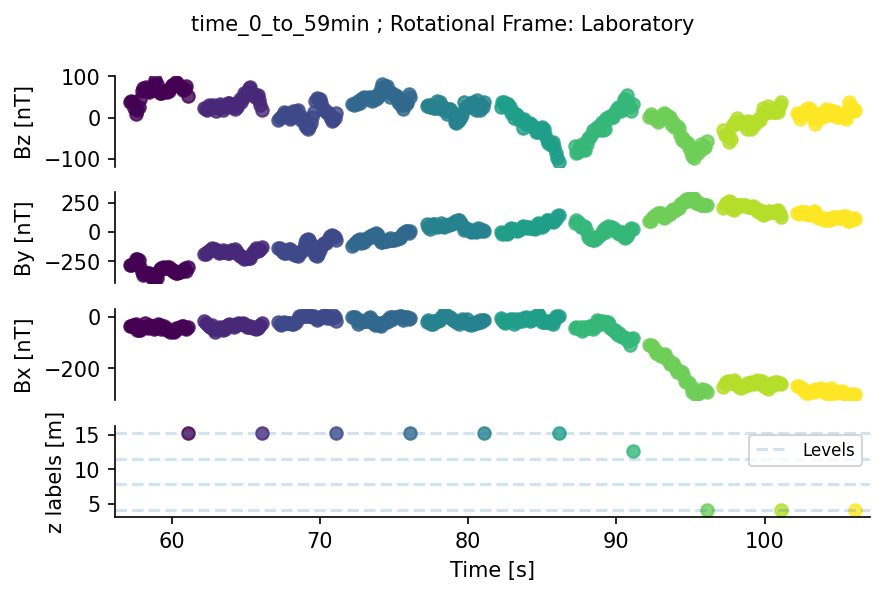

In [4]:
# Prepare time windows:
wdw_pp = 40
train_segm = [0,2,4] if interp == 'phys_model' else [2,3,4]
t_wdws_train, t_wdws_test = ML_twdw.prepare_time_windows(
    data,wdw_pp,train_segm=train_segm,
    plot_instances=True,instances=10,start_wdw=570,stride_pp=50)

### Data augmentation and training dataset size

#### Previous stages

From Stage 1 analysis, we've determined that only the full vector data, meaning all three $(Bx,By,Bz)$ magnetic components, is robust against rotations and has about 90% accuracy for position predictions using a 1-meter threshold.

From Stage 2, we've determined that increasing the number of time window points is associated with better ML performance, up to a certain limit. Using 40 points (equal to 4s) is a good compromise between performance and complexity of the ML model. We also proved that for time windows longer than 2s (20 points), the ML model works much better if Convolutional Neural Networks (CNN) are combined with Dense Neural Networks (DNN).

From Stage 3, we've determined the best main architecture for the ML algorithm: 

* Convolutional block: One-dimensional Convolutional layers (filter,kernel): [32,16] + [32,4]
* Pooling layers: None
* 1D-Conversion layer: Flattening
* Dense layers (neurons): [1024] + [512]

From Stage 4, we've determined the best global hyperparameters:

* Activation function: tanh
* Optimizer: adam
* Learning rate: 5e-4

From Stage 5, we've determined the best parameters for the fine architecture:

* Convolutional layers (filters,kernel): [64,16],[32,4]
* Droupout fraction for all Dense layers: 0.

#### Current stage

In this stage, we explore the effects of artifically augmenting the training dataset on one hand, and of playing with the original size the training dataset on the other.

* Augmentation times = [1, 2, 3]
* Noise options (Bx,By,Bz), in [nT] = [[5,5,5],[10,10,10],[20,20,20],[40,40,40],[60,60,60]]
* Original size of the training dataset: [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [4]:
import numpy as np
# Define additional hyperparameters:
extra_hypers = {
    "Magnetic_Components": ['Bx','By','Bz'],
    "Time_Window_pp": wdw_pp,
    "Dropout_Fraction": 0,
    "Activation_Function": 'tanh',
    "Optimizer": 'adam',
    "Convolutional_Network": True,
    "Conv_Layers": [[16,8],[16,4]],
    "Pool_Layers": [None,None],
    "Dens_Layers": [1024,512],
    "Flatten_Average": True,
    "Learning_Rate": 1e-4,
    "Model_Name": "S6_C8_C4_NP_Flatten_D1024_D512",
}

# Options for hyper-parameters:
p_train_opts = np.arange(0.05,1+1e-9,0.05)
N_augm_opts = [0]
noise_opts = [[5,5,5],[10,10,10],[20,20,20],[40,40,40]] # Noise for Bx,By,Bz components [nT]

# Combine all general hyperparameters:
gen_hyps = hypers | extra_hypers

# Prepare rotational frame options:
RF_opts = list(RFs.values())

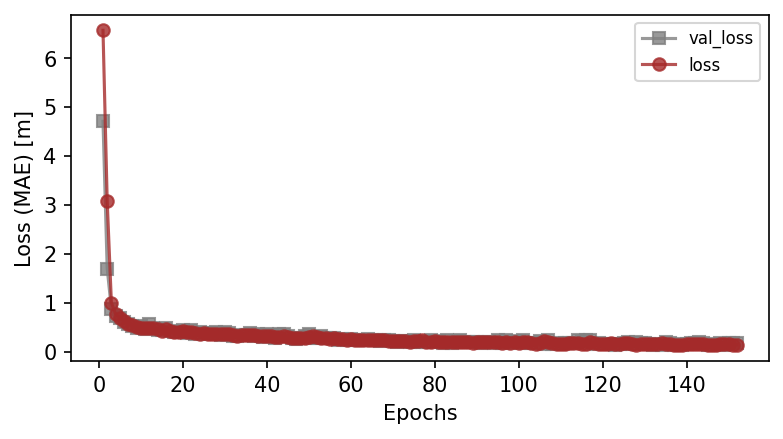

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1500 - val_loss: 0.1731
Epoch 152: early stopping
Restoring model weights from the end of the best epoch: 137.
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
------------------------------
VALIDATING; Accuracy using 1m threshold: 97.7%
------------------------------
 785/6709 ━━━━━━━━━━━━━━━━━━━━ 3s 647us/step

KeyboardInterrupt: 

In [5]:
# Prepare file path to export results:
results_path = f'../Results/'
# Prepare file path to check on already trained models and avoid repetitions:
check_rep_model = f'../Results/Stage6_{interp}_all_Train_s1s4s5_Test_s2s3.csv'

# Train all models:
df_results = ML_MLmodel.train_stage6(
    p_train_opts,N_augm_opts,noise_opts,gen_hyps,RF_opts,
    t_wdws_train,t_wdws_test,interpolation=interp,
    results_path=results_path,
    check_rep_model=check_rep_model,quick_timing_test=False
)